In [1]:
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta, UTC
import boto3
from botocore.config import Config
import matplotlib.pyplot as plt

In [2]:
# Replace with your Polygon.io API key
API_KEY = 'HNZE4DAvb4z5ux2asvBKz_1WGusD_PIR'
aws_access_key_id='0f2fcb6c-d38d-4862-b4d7-8955288d5c11'
aws_secret_access_key='HNZE4DAvb4z5ux2asvBKz_1WGusD_PIR'
SYMBOLS = ["AAPL", "MSFT", "AMZN", "NVDA", "TSLA"]
    #, "GOOGL",  "META",\
    #      "UNH", "V", "XOM", "JPM", "JNJ", "WMT", "MA", "PG", "CVX", "HD", "LLY", "ABBV", \
     #    "BAC", "MRK", "AVGO", "KO", "ORCL", "PEP", "PFE", "TMO", "COST", "QQQ", "CRWD", "TTD"]
interval = "1m"
days_of_data = 30 

In [3]:
SEQ_LEN = 60  # 60 minutes
BIZ_DAYS = 7
INTERVALS_PER_DAY = 390  # 1-min trading intervals

#DEVICE = 'xpu' if torch.xpu.is_available() else 'cpu';
DEVICE='cpu'
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cpu


In [4]:
session = boto3.Session(
  aws_access_key_id=aws_access_key_id,
  aws_secret_access_key=aws_secret_access_key
)

In [5]:
s3 = session.client(
  's3',
  endpoint_url='https://files.polygon.io',
  config=Config(signature_version='s3v4'),
)

In [4]:
def prepare_sequences(df, scaler, seq_len):
    scaled = scaler.fit_transform(df)
    X, y = [], []
    for i in range(seq_len, len(scaled)-1):
        X.append(scaled[i-seq_len:i])
        y.append(scaled[i][0])  # Close
    return np.array(X), np.array(y)


In [5]:
def fetch_polygon_data(symbol, days):
    print(f'symbol {symbol}')
    end = datetime.now(UTC)
    start = end - timedelta(days=days_of_data)
    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/minute/{start.date()}/{end.date()}?adjusted=true&sort=asc&limit=50000&apiKey={API_KEY}"
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data["results"])
    df["t"] = pd.to_datetime(df["t"], unit="ms")
    df.set_index("t", inplace=True)
    df.rename(columns={"o": "Open", "h": "High", "l": "Low", "c": "Close", "v": "Volume"}, inplace=True)
    new_column_order = ['Close','Open','High', 'Low','Volume']
    df = df[new_column_order]
    return df

In [6]:
def add_indicators(df):
    df = df.copy()
    df["macd"] = MACD(df["Close"]).macd()
    df["rsi"] = RSIIndicator(df["Close"]).rsi()
    bb = BollingerBands(df["Close"])
    df["bb_mavg"] = bb.bollinger_mavg()
    df["bb_high"] = bb.bollinger_hband()
    df["bb_low"] = bb.bollinger_lband()
    return df.dropna()
# "['bb_mavg', 'bb_high', 'bb_low']

In [33]:
# MODEL
# ---------------------
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        num_layers = 2
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.fc = nn.Linear(num_layers * hidden_dim, 1)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        out, (hn,cn) = self.lstm(x)
        flattened_hn = hn.view(self.hidden_dim, -1)     
        # return self.fc(out[:, -1])
        return self.fc(flattened_hn)

In [8]:
X_all, y_all = [], []
scaler = MinMaxScaler()
features = ['Close', 'Open', 'High', 'Low', 'Volume', 'macd', 'rsi', 'bb_mavg', 'bb_high', 'bb_low']

for symbol in SYMBOLS:
    df = fetch_polygon_data(symbol, days=25)
    df = add_indicators(df)
    X, y = prepare_sequences(df[features], scaler, SEQ_LEN)
    X_all.append(X)
    y_all.append(y)

X = np.concatenate(X_all)
y = np.concatenate(y_all)


symbol AAPL
symbol MSFT
symbol AMZN
symbol NVDA
symbol TSLA


In [9]:
# Split into train/test
test_steps = INTERVALS_PER_DAY * BIZ_DAYS
X_train, y_train = X[:-test_steps], y[:-test_steps]
X_test, y_test = X[-test_steps:], y[-test_steps:]

X_train = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(DEVICE)
X_test = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(DEVICE)


In [33]:
torch.xpu.init()
torch.xpu.reset_peak_memory_stats()
torch.xpu.reset_accumulated_memory_stats()
# torch.xpu.empty_cache()

In [34]:
# ---------------------
# TRAINING
# ---------------------
model = LSTMModel(input_dim=X.shape[2]).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
epochs = 25
model.train()
for epoch in range(epochs):
    output = model(X_train)
    loss = criterion(output, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # torch.xpu.empty_cache()
    print(f"Epoch {epoch+1} Loss: {loss.item():.6f}")


RuntimeError: [enforce fail at alloc_cpu.cpp:121] data. DefaultCPUAllocator: not enough memory: you tried to allocate 24146145280 bytes.

In [25]:
model.eval()
with torch.no_grad():
    pred_test = model(X_test).cpu().numpy().flatten()
    future_preds = []
    
    seq = X_test[-1].unsqueeze(0)
    for _ in range(test_steps):
        npred = model(seq)
        future_preds.append(npred.item())
    
        # Build next input
        last_features = seq[:, -1, 1:].detach()  # remove close
        new_point = torch.cat([npred, last_features], dim=-1)  # shape: (1, input_dim)
        new_point = new_point.unsqueeze(1)  # shape: (1, 1, input_dim)
    
        # Slide window and append
        seq = torch.cat([seq[:, 1:, :], new_point], dim=1)

In [26]:
# -----------------------
future_steps = 7 * 270
last_seq = X_test[-1:].clone()
future_preds = []

model.eval()
with torch.no_grad():
    for _ in range(future_steps):
        next_pred = model(last_seq)
        future_preds.append(next_pred.item())

        # Fix dimension mismatch here
        pred_close = next_pred.squeeze()                    # scalar
        last_feats = last_seq[:, -1, 1:].squeeze(0)         # (input_dim - 1,)
        next_input = torch.cat([pred_close.unsqueeze(0), last_feats], dim=0)  # (input_dim,)
        next_input = next_input.unsqueeze(0).unsqueeze(0)   # (1, 1, input_dim)

        # Slide window
        last_seq = torch.cat([last_seq[:, 1:, :], next_input], dim=1)


In [27]:
# 🔄 Inverse Transform
y_test_true = scaler.inverse_transform(np.column_stack((y_test.cpu(), np.zeros((len(y_test), scaler.n_features_in_-1)))))[:,0]
pred_test_true = scaler.inverse_transform(np.column_stack((pred_test, np.zeros((len(pred_test), scaler.n_features_in_-1)))))[:,0]
future_true = scaler.inverse_transform(np.column_stack((future_preds, np.zeros((len(future_preds), scaler.n_features_in_-1)))))[:,0]


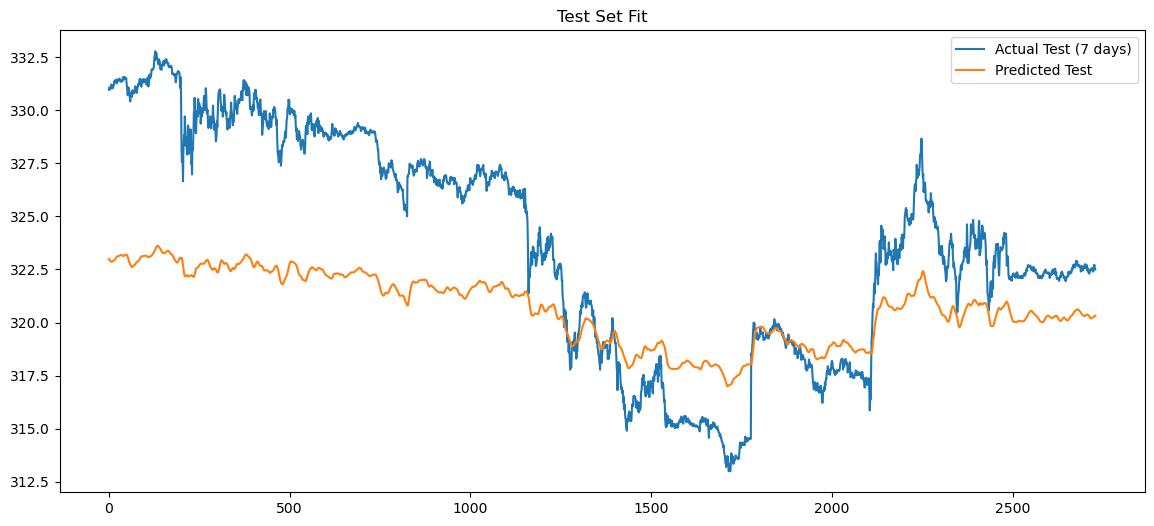

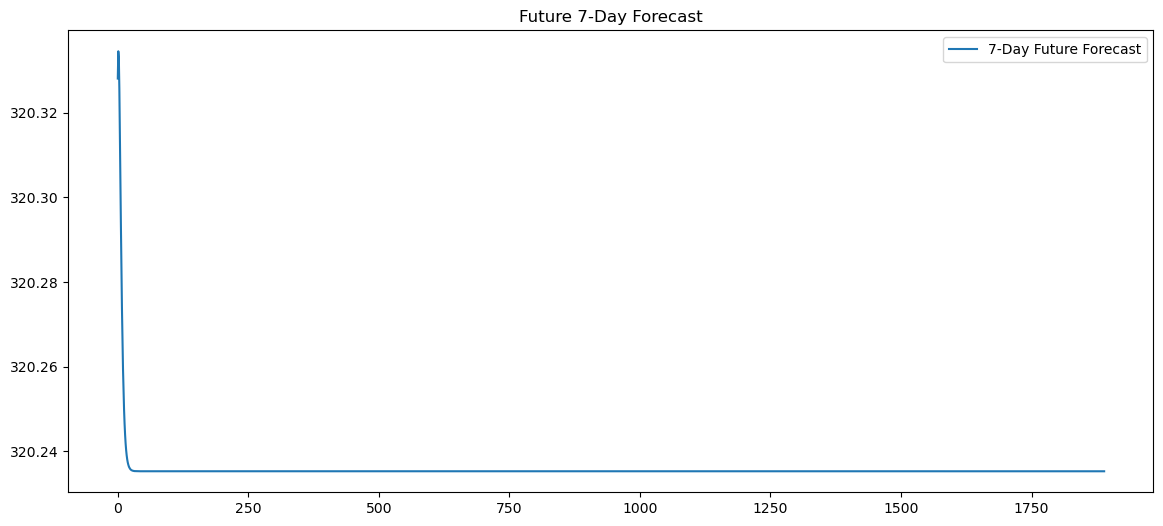

In [28]:


plt.figure(figsize=(14,6))
plt.plot(y_test_true, label='Actual Test (7 days)')
plt.plot(pred_test_true, label='Predicted Test')
plt.legend(); plt.title('Test Set Fit'); plt.show()

plt.figure(figsize=(14,6))
plt.plot(future_true, label='7-Day Future Forecast')
plt.legend(); plt.title('Future 7-Day Forecast'); plt.show()